<a href="https://www.kaggle.com/code/mehmet0sahinn/cross-lingual-ner-adaptation?scriptVersionId=254026766" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

This notebook presents a cross-lingual NER adaptation to Turkish with a fine-tuned xlm-roberta-base model, evaluated in three phases:

- Phase 1: EN and TR Benchmark results of XLM-R (fine-tuned on TR)
- Phase 2: EN and TR Benchmark results of XLM-R (fine-tuned on EN)
- Phase 3: EN and TR Benchmark results of XLM-R (fine-tuned on EN + [Incremental TR])

# 1 Load The Dataset

In [1]:
!pip install -q datasets transformers seqeval --no-deps

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from datasets import load_dataset, DatasetDict
from collections import defaultdict

def load_panx_datasets(langs):
    panx_ch = defaultdict(DatasetDict)
    for lang in langs:
        ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
        for split in ds:
            panx_ch[lang][split] = ds[split].shuffle(seed=0)
    return panx_ch

In [3]:
langs=["en","tr"]
panx_ch = load_panx_datasets(langs)

README.md: 0.00B [00:00, ?B/s]

PAN-X.en/train-00000-of-00001.parquet:   0%|          | 0.00/942k [00:00<?, ?B/s]

PAN-X.en/validation-00000-of-00001.parqu(…):   0%|          | 0.00/472k [00:00<?, ?B/s]

PAN-X.en/test-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

PAN-X.tr/train-00000-of-00001.parquet:   0%|          | 0.00/994k [00:00<?, ?B/s]

PAN-X.tr/validation-00000-of-00001.parqu(…):   0%|          | 0.00/503k [00:00<?, ?B/s]

PAN-X.tr/test-00000-of-00001.parquet:   0%|          | 0.00/504k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
# number of data
import pandas as pd

pd.DataFrame(
    {lang: [
        panx_ch[lang]["train"].num_rows,
        panx_ch[lang]["validation"].num_rows,
        panx_ch[lang]["test"].num_rows
    ] for lang in langs},
    index=["Train", "Validation", "Test"])

,en,tr
Train,20000,20000
Validation,10000,10000
Test,10000,10000


# 2 EDA & Data Preprocessing

## 2.1 Feature Items

In [5]:
#features
for key, value in panx_ch["en"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


## 2.2 NER Tags

In [6]:
# NER Tags
tags = panx_ch["en"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


## 2.3 An Example

In [7]:
# first context in English Train
element = panx_ch["en"]["train"][2]

for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['Vaivara', 'concentration', 'camp', ',', 'Vaivara', '(', "''1943–1944", ',', 'during', 'German', 'occupation', "''", ')']
ner_tags: [5, 6, 6, 0, 5, 0, 0, 0, 0, 3, 4, 0, 0]
langs: ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en']


In [8]:
def ner_tags_int2str(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_en = panx_ch["en"].map(ner_tags_int2str)

en_example = panx_en["train"][2]

pd.DataFrame(
    [en_example["tokens"], en_example["ner_tags_str"]],
    index=["Tokens", "Tags"])

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12
Tokens,Vaivara,concentration,camp,",",Vaivara,(,''1943–1944,",",during,German,occupation,'',)
Tags,B-LOC,I-LOC,I-LOC,O,B-LOC,O,O,O,O,B-ORG,I-ORG,O,O


In [9]:
# number of B- tags in en

from collections import Counter

split2freqs = defaultdict(Counter)

for split, dataset in panx_en.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient="index")

,ORG,PER,LOC
train,9422,9164,9345
validation,4677,4635,4834
test,4745,4556,4657


# 3 Tokenizer and Label Alignment

In [10]:
from transformers import AutoTokenizer

xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

## 3.1 XLM-R Tokenization Mechanism (SentencePiece-based)

In [11]:
text_example = "Mehmet Sahin lives in Halle!"

xlmr_tokens = xlmr_tokenizer(text_example).tokens()

pd.DataFrame([xlmr_tokens], index = ["XLM-R"])

,0,1,2,3,4,5,6,7,8
XLM-R,<s>,▁Mehmet,▁Sahi,n,▁lives,▁in,▁Halle,!,</s>


## 3.2 Token-level Entity Prediction

In [12]:
from transformers import XLMRobertaForTokenClassification
import torch

xlmr_model_name = "xlm-roberta-base"
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
num_labels = tags.num_classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xlmr_model = XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name,
                                                              num_labels = num_labels,
                                                              id2label=index2tag,
                                                              label2id=tag2index
).to(device)

2025-08-03 20:10:29.411170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754251829.752727      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754251829.859576      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def ner_infer(text, tags, model, tokenizer):
    tokens = tokenizer(text).tokens()
    input_ids = xlmr_tokenizer.encode(text,
                                      return_tensors = "pt").to(device)
    outputs = model(input_ids)[0]
    predictions = torch.argmax(outputs, dim=2)
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index = ["Tokens", "Tags"])

In [14]:
# a zero-shot example
ner_infer(text_example, tags, xlmr_model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8
Tokens,<s>,▁Mehmet,▁Sahi,n,▁lives,▁in,▁Halle,!,</s>
Tags,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG


## 3.3 Label Alignment

In [15]:
def tokenize_and_align_labels(example_batch):
    tokenized_batch = xlmr_tokenizer(
        example_batch["tokens"],
        truncation=True,
        is_split_into_words=True
    )

    aligned_label_batch = []

    for example_idx, word_labels in enumerate(example_batch["ner_tags"]):
        word_ids = tokenized_batch.word_ids(batch_index=example_idx)
        previous_word_id = None
        label_ids = []

        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != previous_word_id:
                label_ids.append(word_labels[word_id])
            else:
                label_ids.append(-100)
            previous_word_id = word_id

        aligned_label_batch.append(label_ids)

    tokenized_batch["labels"] = aligned_label_batch
    return tokenized_batch

In [16]:
def encode_panx_dataset(dataset_split):
    return dataset_split.map(tokenize_and_align_labels,
                     batched=True,
                     remove_columns=["langs", "ner_tags", "tokens"])

panx_en_encoded = encode_panx_dataset(panx_ch["en"])

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [17]:
example = panx_en_encoded["train"][2]

tokens = xlmr_tokenizer.convert_ids_to_tokens(example["input_ids"])
label_ids = example["labels"]
label_names = [index2tag[label] if label != -100 else "IGN" for label in label_ids]

pd.DataFrame(
    [tokens, label_ids, label_names],
    index=["Tokens", "Label IDs", "Labels"])

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
Tokens,<s>,▁Vai,vara,▁concentration,▁camp,▁,",",▁Vai,vara,▁(,...,1944,▁,",",▁during,▁German,▁,occupation,▁'',▁),</s>
Label IDs,-100,5,-100,6,6,0,-100,5,-100,0,...,-100,0,-100,0,3,4,-100,0,0,-100
Labels,IGN,B-LOC,IGN,I-LOC,I-LOC,O,IGN,B-LOC,IGN,O,...,IGN,O,IGN,O,B-ORG,I-ORG,IGN,O,O,IGN


## 3.4 Preparing Batched Inputs with Data Collator

In [18]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

# 4. Model Training

## 4.1 Defining Training Arguments

In [19]:
from transformers import TrainingArguments
def get_training_arguments(output_dir="xlm-roberta-ner-multi",
                           num_epochs=2,
                           batch_size=16,
                           dataset_length=None,
                           push_to_hf=False
                          ):

    return TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        logging_steps=dataset_length // batch_size,
        push_to_hub=push_to_hf,
        report_to="none",
    )

## 4.2 Evaluation Metrics

In [20]:
import numpy as np

def align_predictions(predictions, label_ids):
    pred_ids = np.argmax(predictions, axis=2)
    batch_size, seq_len = pred_ids.shape

    true_labels = []
    pred_labels = []

    for batch_idx in range(batch_size):
        example_true = []
        example_pred = []
        for token_idx in range(seq_len):
            true_label_id = label_ids[batch_idx][token_idx]
            pred_label_id = pred_ids[batch_idx][token_idx]

            if true_label_id != -100:
                example_true.append(index2tag[true_label_id])
                example_pred.append(index2tag[pred_label_id])

        true_labels.append(example_true)
        pred_labels.append(example_pred)

    return pred_labels, true_labels

In [21]:
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics(eval_pred):
    predictions, label_ids = eval_pred
    y_pred, y_true = align_predictions(predictions, label_ids)
    return {
        "accuracy": accuracy_score(y_true,y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred)}

In [22]:
def get_f1_score(model, dataset):
    return model.predict(dataset).metrics["test_f1"]

f1_scores_tr = defaultdict(dict)
f1_scores_en = defaultdict(dict)

# 5. Results

## Phase 1: EN and TR Benchmark results of XLM-R (fine-tuned on TR)

In [23]:
panx_tr_encoded = encode_panx_dataset(panx_ch["tr"])

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [24]:
from transformers import Trainer

training_args = get_training_arguments(
    output_dir="xlm-roberta-ner-tr",
    dataset_length=len(panx_tr_encoded["train"])
)

model_ft_tr = Trainer(model = xlmr_model,
                                   args = training_args,
                                   tokenizer = xlmr_tokenizer,
                                   train_dataset = panx_tr_encoded["train"],
                                   eval_dataset = panx_tr_encoded["validation"],
                                   data_collator = data_collator,
                                   compute_metrics = compute_metrics
                                  )
model_ft_tr.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.143773,0.959278,0.869488,0.899978,0.884470
2,0.228800,0.131122,0.963717,0.889340,0.908486,0.898811


TrainOutput(global_step=1250, training_loss=0.2287742919921875, metrics={'train_runtime': 609.5152, 'train_samples_per_second': 65.626, 'train_steps_per_second': 2.051, 'total_flos': 779989745413824.0, 'train_loss': 0.2287742919921875, 'epoch': 2.0})

In [25]:
# NER Analysis with Turkish Sentences

text_en = "Alan Mathison Turing was an English mathematician, computer scientist from London." 

ner_infer(text_en, tags, model_ft_tr.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Tokens,<s>,▁Alan,▁Math,ison,▁Tur,ing,▁was,▁an,▁English,▁math,e,matic,ian,",",▁computer,▁scientist,▁from,▁London,.,</s>
Tags,O,B-PER,I-PER,I-PER,I-PER,I-PER,O,O,O,O,O,O,O,O,O,O,O,B-LOC,O,O


In [26]:
# NER Analysis with Turkish Sentences

text_tr = "Vardar Kapısı'ndan çıkarken nişanlarımı söktüm, biraz müteessirdim. Böyle yakındı Enver Paşa"

ner_infer(text_tr, tags, model_ft_tr.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
Tokens,<s>,▁Var,dar,▁Kap,ısı,',ndan,▁çıkar,ken,▁nişan,...,si,rdim,.,▁Böyle,▁yakın,dı,▁En,ver,▁Paşa,</s>
Tags,O,B-LOC,I-LOC,I-LOC,I-ORG,O,O,O,O,O,...,O,O,O,O,O,O,B-PER,B-PER,I-PER,O


In [27]:
# PHASE 2: EN BENCHMARK RESULTS

f1_scores_tr["en"] = get_f1_score(model_ft_tr, panx_en_encoded["test"])
print(f"English F1-Score on XLM-R[TR]: {f1_scores_tr['en']:.3f}")

English F1-Score on XLM-R[TR]: 0.631


In [28]:
# PHASE 1: TR BENCHMARK RESULTS

f1_scores_tr["tr"] = get_f1_score(model_ft_tr, panx_tr_encoded["test"])
print(f"Turkish F1-Score on XLM-R[TR]: {f1_scores_tr['tr']:.3f}")

Turkish F1-Score on XLM-R[TR]: 0.899


## Phase 2: EN and TR Benchmark results of XLM-R (fine-tuned on EN)

In [29]:
del model_ft_tr
import gc, torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect() 

In [30]:
from transformers import Trainer

training_args = get_training_arguments(
    output_dir="xlm-roberta-ner-en",
    dataset_length=len(panx_en_encoded["train"])
)

model_ft_en = Trainer(model = xlmr_model,
                                   args = training_args,
                                   tokenizer = xlmr_tokenizer,
                                   train_dataset = panx_en_encoded["train"],
                                   eval_dataset = panx_en_encoded["validation"],
                                   data_collator = data_collator,
                                   compute_metrics = compute_metrics
                                  )
model_ft_en.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.264492,0.920334,0.782738,0.818040,0.800000
2,0.279700,0.251951,0.924406,0.800825,0.823696,0.812099


TrainOutput(global_step=1250, training_loss=0.27967666015625, metrics={'train_runtime': 625.6923, 'train_samples_per_second': 63.929, 'train_steps_per_second': 1.998, 'total_flos': 857353413497856.0, 'train_loss': 0.27967666015625, 'epoch': 2.0})

In [31]:
# PHASE 2: EN BENCHMARK RESULTS
f1_scores_en["en"] = get_f1_score(model_ft_en, panx_en_encoded["test"])
print(f"English F1-Score on XLM-R[EN]: {f1_scores_en['en']:.3f}")

English F1-Score on XLM-R[EN]: 0.809


In [32]:
# PHASE 2: TR BENCHMARK RESULTS

f1_scores_en["tr"] = get_f1_score(model_ft_en, panx_tr_encoded["test"])
print(f"Turkish F1-Score on XLM-R[EN]: {f1_scores_en['tr']:.3f}")

Turkish F1-Score on XLM-R[EN]: 0.872


## Phase 3: EN and TR Benchmark results of XLM-R (fine-tuned on EN + [Incremental TR])

In [33]:
# subset training function for tr
def train_on_subset(dataset,
                    num_samples,
                    output_dir="ner-subset"
                   ):

    train_subset = dataset["train"].shuffle(seed=42).select(range(num_samples))
    val_set = dataset["validation"]
    test_ds = dataset["test"]
    
    training_args = get_training_arguments(output_dir,
                                           dataset_length=len(train_subset),
                                           push_to_hf=False
                                          )

    sub_model_trainer = Trainer(model = model_ft_en.model,
                           args = training_args,
                           tokenizer = xlmr_tokenizer,
                           train_dataset = train_subset,
                           eval_dataset = val_set,
                           data_collator = data_collator,
                           compute_metrics = compute_metrics
                                      )

    sub_model_trainer.train()
    # sub_model_trainer.push_to_hub(commit_message="Training has been completed successfully!")

    f1_score_tr = get_f1_score(sub_model_trainer, test_ds)
    f1_score_en = get_f1_score(sub_model_trainer, panx_en_encoded["test"])
    return pd.DataFrame.from_dict(
        {"EN-FT Samples": len(panx_en_encoded["train"]),
         "TR-FT Samples": [len(train_subset)],
         "English F1-Score": [f1_score_en],
         "Turkish F1-Score": [f1_score_tr]
                })

In [34]:
metrics_df = pd.DataFrame()

for size in [250, 500, 1000, 2000, 5000, 10000, 20000]:
    metrics_df = metrics_df._append(train_on_subset(panx_tr_encoded, num_samples=size, output_dir="xlm-roberta-base-cased-ner-turkish"),
                                   ignore_index = True)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.145540,0.959173,0.879665,0.892876,0.886221
2,0.126000,0.147276,0.958870,0.874031,0.892654,0.883244


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.148838,0.961083,0.893040,0.901827,0.897412
2,0.092100,0.150752,0.960846,0.892150,0.899608,0.895863


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.153854,0.960227,0.890658,0.893689,0.892171
2,0.084000,0.153426,0.961478,0.885161,0.905526,0.895228


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.146320,0.961925,0.883422,0.909891,0.896461
2,0.093600,0.145136,0.963730,0.893344,0.911519,0.902340


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.133418,0.963493,0.894140,0.909817,0.901910
2,0.097300,0.136018,0.965034,0.900400,0.914922,0.907603


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.123938,0.966733,0.898035,0.916106,0.906980
2,0.093000,0.125991,0.968405,0.908707,0.922690,0.915645


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.117577,0.968589,0.908089,0.920249,0.914128
2,0.085500,0.117360,0.971039,0.916752,0.927943,0.922313


In [35]:
# Benchmark Scores

metrics_df

,EN-FT Samples,TR-FT Samples,English F1-Score,Turkish F1-Score
0,20000,250,0.798714,0.881073
1,20000,500,0.800014,0.890231
2,20000,1000,0.783196,0.888816
3,20000,2000,0.786830,0.896976
4,20000,5000,0.787723,0.905009
5,20000,10000,0.778420,0.911066
6,20000,20000,0.765162,0.921589


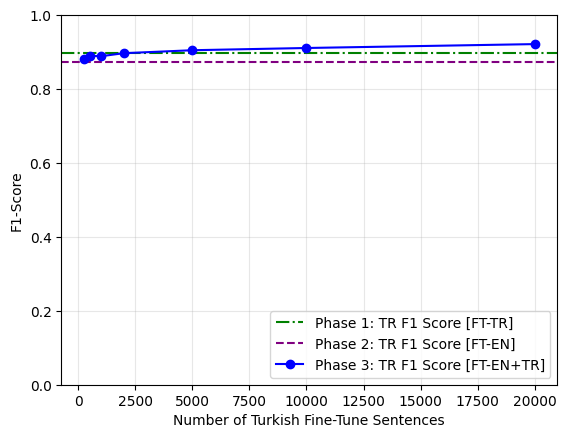

In [36]:
import matplotlib.pyplot as plt
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
fig, ax = plt.subplots()

ax.axhline(f1_scores_tr['tr'], ls="-.",  color="g",
           label="Phase 1: TR F1 Score [FT-TR]")    # Phase 1 
ax.axhline(f1_scores_en['tr'], ls="--", color="purple",
           label="Phase 2: TR F1 Score [FT-EN]")    # Phase 2

metrics_df.set_index("TR-FT Samples")["Turkish F1-Score"].plot(ax=ax,
                                                               marker="o",
                                                               color='blue',
                                                               label="Phase 3: TR F1 Score [FT-EN+TR]") # Phase 3

plt.ylim((0,1))
plt.xlabel("Number of Turkish Fine-Tune Sentences")
plt.ylabel("F1-Score")
ax.grid(True, alpha=.3)
ax.legend(loc="lower right")
plt.show()

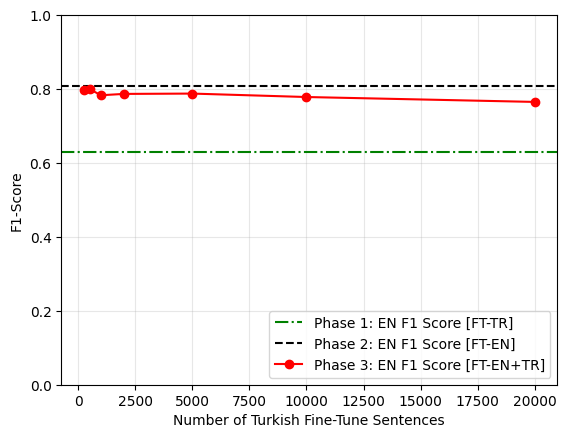

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.axhline(f1_scores_tr['en'], ls="-.",  color="green",
           label="Phase 1: EN F1 Score [FT-TR]")    # Phase 1 
ax.axhline(f1_scores_en['en'], ls="--", color="black",
           label="Phase 2: EN F1 Score [FT-EN]")    # Phase 2

metrics_df.set_index("TR-FT Samples")["English F1-Score"].plot(ax=ax,
                                                               marker="o",
                                                               color="red",
                                                               label="Phase 3: EN F1 Score [FT-EN+TR]") # Phase 3

plt.ylim((0,1))
plt.xlabel("Number of Turkish Fine-Tune Sentences")
plt.ylabel("F1-Score")
ax.grid(True, alpha=.3)
ax.legend(loc="lower right")
plt.show()